<a href="https://colab.research.google.com/github/bessszilard/Udacity-Self-Driving-Car-Engineer-Nanodegree-Program/blob/master/Project-4-Behavioral-Cloning/Behavioral_cloning_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/bessszilard/Self-Driving-Car-Simulator-Data

fatal: destination path 'Self-Driving-Car-Simulator-Data' already exists and is not an empty directory.


In [2]:
!ls
!ls Self-Driving-Car-Simulator-Data

model.h5  sample_data  Self-Driving-Car-Simulator-Data
driving_log.csv  IMG  LICENSE  README.md


In [3]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPool2D, Dropout, Flatten, Dense, Lambda
from keras.layers import Cropping2D, Conv2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import random
from google.colab import files

Using TensorFlow backend.


In [0]:
# lines = []
# with open("../data/driving_log.csv") as csvfile:
#     reader = csv.reader(csvfile)
#     for line in reader:
#         lines.appedn

0.0


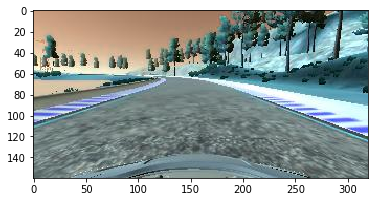

In [6]:
# datadir = 'Self-Driving-Car-Simulator-Data'
# colums = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
# data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = colums)
# pd.set_option('display.max_colwidth', -1)
# data.head()

lines = []
with open('Self-Driving-Car-Simulator-Data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
images = []
measurements = []

def path_to_image(dir, line):
    filename = source_path.split('\\')[-1] 
    current_path = dir + filename
    return cv2.imread(current_path)

for line in lines:
    steering_center = float(line[3])
    
    # create adjusted steering measurements for the side camera images
    correction = 0.2 # this is a parameter to tune
    steering_left = steering_center + correction
    steering_right = steering_center - correction
            
    source_path = line[0]
    filename = source_path.split('\\')[-1]
    current_path = 'Self-Driving-Car-Simulator-Data/IMG/' + filename
    
    image = cv2.imread(current_path)
    
    dir = 'Self-Driving-Car-Simulator-Data/IMG/'
    image_center = path_to_image(dir, line[0])
#     image_left   = path_to_image(dir, line[1])
#     image_right  = path_to_image(dir, line[2])
    
    images.append(image_center)
    measurement = float(line[3])
    measurements.append(measurement)
#     images.extend((image_center, image_left, image_right))
#     measurements.extend((steering_center, steering_left, steering_right))

augmented_images = images
augemented_measurements = measurements
augmented_images, augemented_measurements = [], []    
for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augemented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image, 1))
    augemented_measurements.append(-measurement)


-0.01886792


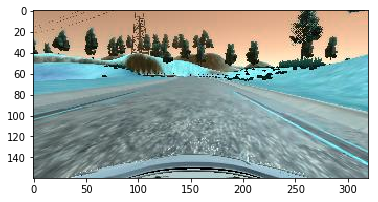

In [8]:
index = random.randint(0, len(measurements)-1)
plt.imshow(images[index])
print(measurements[index])

In [0]:
#clear RAM

X_train = np.array(augmented_images)
y_train = np.array(augemented_measurements)
del augmented_images, augemented_measurements
del lines, images

In [25]:
model = Sequential()
model.add(Lambda(lambda x: ((x / 255.0) - 0.5), input_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((70, 25),(0, 0))))
model.add(Conv2D(24, (5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Dropout(0.5))
model.add(Dense(1))

optimizer = Adam(lr = 1e-4)
model.compile(loss='mse', optimizer=optimizer)
history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=7)

Train on 11465 samples, validate on 2867 samples
Epoch 1/7
11465/11465 [==============================] - 20s 2ms/step - loss: 0.0133 - val_loss: 0.0065
Epoch 2/7
11465/11465 [==============================] - 16s 1ms/step - loss: 0.0112 - val_loss: 0.0054
Epoch 3/7
11465/11465 [==============================] - 16s 1ms/step - loss: 0.0101 - val_loss: 0.0048
Epoch 4/7
11465/11465 [==============================] - 16s 1ms/step - loss: 0.0096 - val_loss: 0.0044
Epoch 5/7
11465/11465 [==============================] - 16s 1ms/step - loss: 0.0092 - val_loss: 0.0041
Epoch 6/7
11465/11465 [==============================] - 16s 1ms/step - loss: 0.0090 - val_loss: 0.0045
Epoch 7/7
11465/11465 [==============================] - 16s 1ms/step - loss: 0.0085 - val_loss: 0.0047


dict_keys(['val_loss', 'loss'])


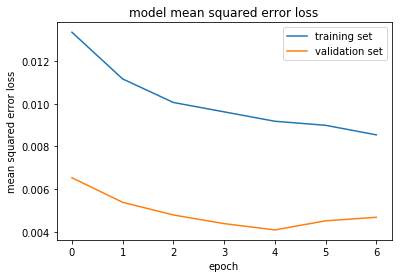

In [26]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [0]:
model.save('model.h5')
# !ls
files.download('model.h5')